## 0. 필요 모듈 import

In [93]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [94]:
# 한글폰트 설정, 그래프 마이너스 표시 설정
import matplotlib
from matplotlib import font_manager,rc
from matplotlib import pyplot as plt
import platform
import seaborn as sns

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

In [95]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## 1. 데이터 불러오기

In [96]:
df_org = pd.read_csv('../data/에버랜드/final에버랜드.csv', encoding='cp949')
df_org = df_org.set_index('date')
df = df_org.copy()
df.head()

,일간입장객,요일,공휴일,최저기온(℃),최고기온(℃),강수량(mm),최대풍속(m/s),평균풍속(m/s),PM2.5,PM10,네비게이션,승차총승객수,하차총승객수,행사
date,,,,,,,,,,,,,,
2018-01-01,12732,1,1,-8.7,4.2,0.0,6.1,1.2,30,55,770,45872,45872,1
2018-01-02,5432,2,0,-8.0,3.6,0.0,6.6,1.3,37,61,362,80096,80096,1
2018-01-03,3815,3,0,-9.8,1.8,0.0,6.3,1.5,24,45,270,82054,82054,1
2018-01-04,3689,4,0,-10.6,-0.9,0.0,2.9,0.9,34,61,313,82888,82888,1
2018-01-05,4167,5,0,-8.3,2.5,0.0,6.9,1.3,47,77,365,86732,86732,1


In [97]:
# 추정치의 흡수율인 0.14를 곱함(가중치 반영)
df['승차총승객수'] = df['승차총승객수']*0.19
df['하차총승객수'] = df['하차총승객수']*0.19

In [98]:
df.drop(['승차총승객수', '최대풍속(m/s)','승차총승객수','하차총승객수'], axis=1,inplace=True)

In [99]:
df.head()

,일간입장객,요일,공휴일,최저기온(℃),최고기온(℃),강수량(mm),평균풍속(m/s),PM2.5,PM10,네비게이션,행사
date,,,,,,,,,,,
2018-01-01,12732,1,1,-8.7,4.2,0.0,1.2,30,55,770,1
2018-01-02,5432,2,0,-8.0,3.6,0.0,1.3,37,61,362,1
2018-01-03,3815,3,0,-9.8,1.8,0.0,1.5,24,45,270,1
2018-01-04,3689,4,0,-10.6,-0.9,0.0,0.9,34,61,313,1
2018-01-05,4167,5,0,-8.3,2.5,0.0,1.3,47,77,365,1


In [8]:
df.columns

Index(['일간입장객', '요일', '공휴일', '최저기온(℃)', '최고기온(℃)', '강수량(mm)', '평균풍속(m/s)',
       'PM2.5', 'PM10', '네비게이션', '하차총승객수', '행사'],
      dtype='object')

## 2. 데이터 탐색

### 2.1. 타겟값 로그변환

<AxesSubplot:title={'center':'Original 에버랜드 일일 방문객 Histogram'}, xlabel='일간입장객', ylabel='Density'>

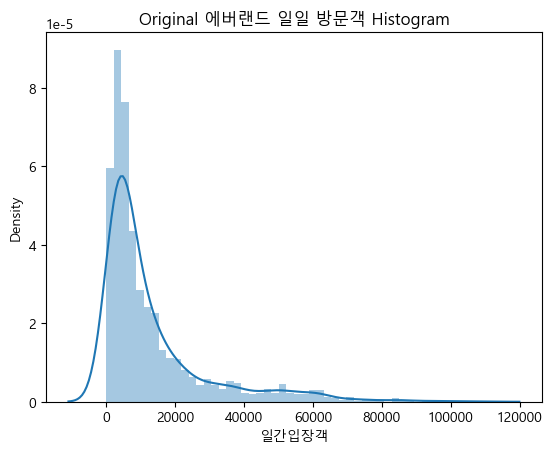

In [100]:
plt.title('Original 에버랜드 일일 방문객 Histogram')
sns.distplot(df['일간입장객'])

- 데이터가 왼쪽으로 치우쳐져 있음(=오른 꼬리가 긴 형태)
- 로그변환 필요

<AxesSubplot:title={'center':'Log Transformed 에버랜드 일일 방문객 Histogram'}, xlabel='일간입장객', ylabel='Density'>

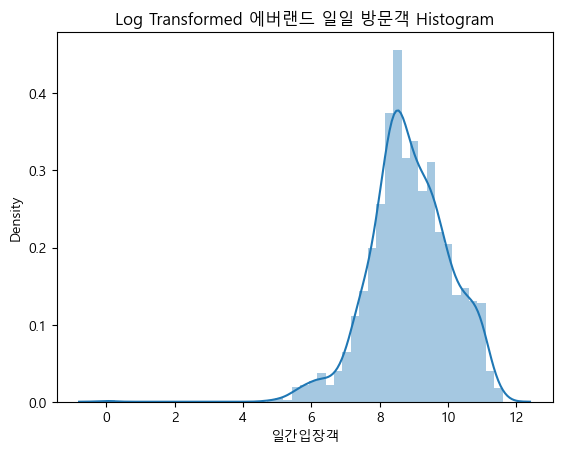

In [101]:
# 결과값을 로그 변환하고 다시 분포도 확인
plt.title('Log Transformed 에버랜드 일일 방문객 Histogram')
log_DailyTotal = np.log1p(df['일간입장객'])
sns.distplot(log_DailyTotal)

In [102]:
# Daily_Total 로그 변환
original_DailyTotal = df['일간입장객'] #원래값 저장
df['Daily_Total'] = np.log1p(df['일간입장객']) #로그변환 값으로 타겟값을 대체

In [103]:
df = df.drop('일간입장객',  axis=1)
df.head()

,요일,공휴일,최저기온(℃),최고기온(℃),강수량(mm),평균풍속(m/s),PM2.5,PM10,네비게이션,행사,Daily_Total
date,,,,,,,,,,,
2018-01-01,1,1,-8.7,4.2,0.0,1.2,30,55,770,1,9.451952
2018-01-02,2,0,-8.0,3.6,0.0,1.3,37,61,362,1,8.600247
2018-01-03,3,0,-9.8,1.8,0.0,1.5,24,45,270,1,8.246958
2018-01-04,4,0,-10.6,-0.9,0.0,0.9,34,61,313,1,8.213382
2018-01-05,5,0,-8.3,2.5,0.0,1.3,47,77,365,1,8.335192


### 2.2. 범주형 데이터 원핫인코딩

In [104]:
# 요일, Holiday, 행사 컬럼 원핫인코딩
print('get_dummies() 수행 전 데이터 Shape:', df.shape)
df_ohe = pd.get_dummies(df, columns=['요일','공휴일', '행사'])
print('get_dummies() 수행 후 데이터 Shape:', df_ohe.shape)

get_dummies() 수행 전 데이터 Shape: (1642, 11)
get_dummies() 수행 후 데이터 Shape: (1642, 19)


## 3. 선형회귀모델의 학습/예측/평가

### 3.1. 함수생성 및 데이터 분할

In [105]:
# 단일 모델의 RMSE 값 반환
def get_rmse(model): # 학습된 모델을 받아서 예측
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 여러 모델의 RMSE 값 반환
def get_rmses(models) :
    rmses = []
    for model in models :
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

# 단일 모델의 MAE 값 반환
def get_mae(model): # 학습된 모델을 받아서 예측
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test , pred)
    print('{0} 로그 변환된 MAE: {1}'.format(model.__class__.__name__,np.round(mae, 3)))
    return mae

# 여러 모델의 MAE 값 반환
def get_maes(models) :
    maes = []
    for model in models :
        mae = get_mae(model)
        maes.append(mae)
    return maes

In [106]:
## 데이터 분할
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 타깃과 피처
y_target = df_ohe['Daily_Total']
X_features = df_ohe.drop('Daily_Total',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

### 3.2. 일반모델 학습/예측/평가

In [107]:
# 일반 선형 회귀
lr_reg = LinearRegression() 
lr_reg.fit(X_train, y_train)

# 릿찌회귀
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

# 라쏘 회귀
lasso_reg=Lasso()
lasso_reg.fit(X_train,y_train)

Lasso()

In [108]:
models= [lr_reg, ridge_reg, lasso_reg]
get_rmses(models) #학습된 모델 전달하고 rmse값 반환
get_maes(models)

LinearRegression 로그 변환된 RMSE: 0.767
Ridge 로그 변환된 RMSE: 0.766
Lasso 로그 변환된 RMSE: 0.979
LinearRegression 로그 변환된 MAE: 0.587
Ridge 로그 변환된 MAE: 0.587
Lasso 로그 변환된 MAE: 0.789


[0.5872824000007963, 0.5869857400165372, 0.7889190125273846]

- Lasso 모델이 상대적으로 결과가 좋게 나옴
- Ridge 모델과 LR 결과는 비슷하게 나옴

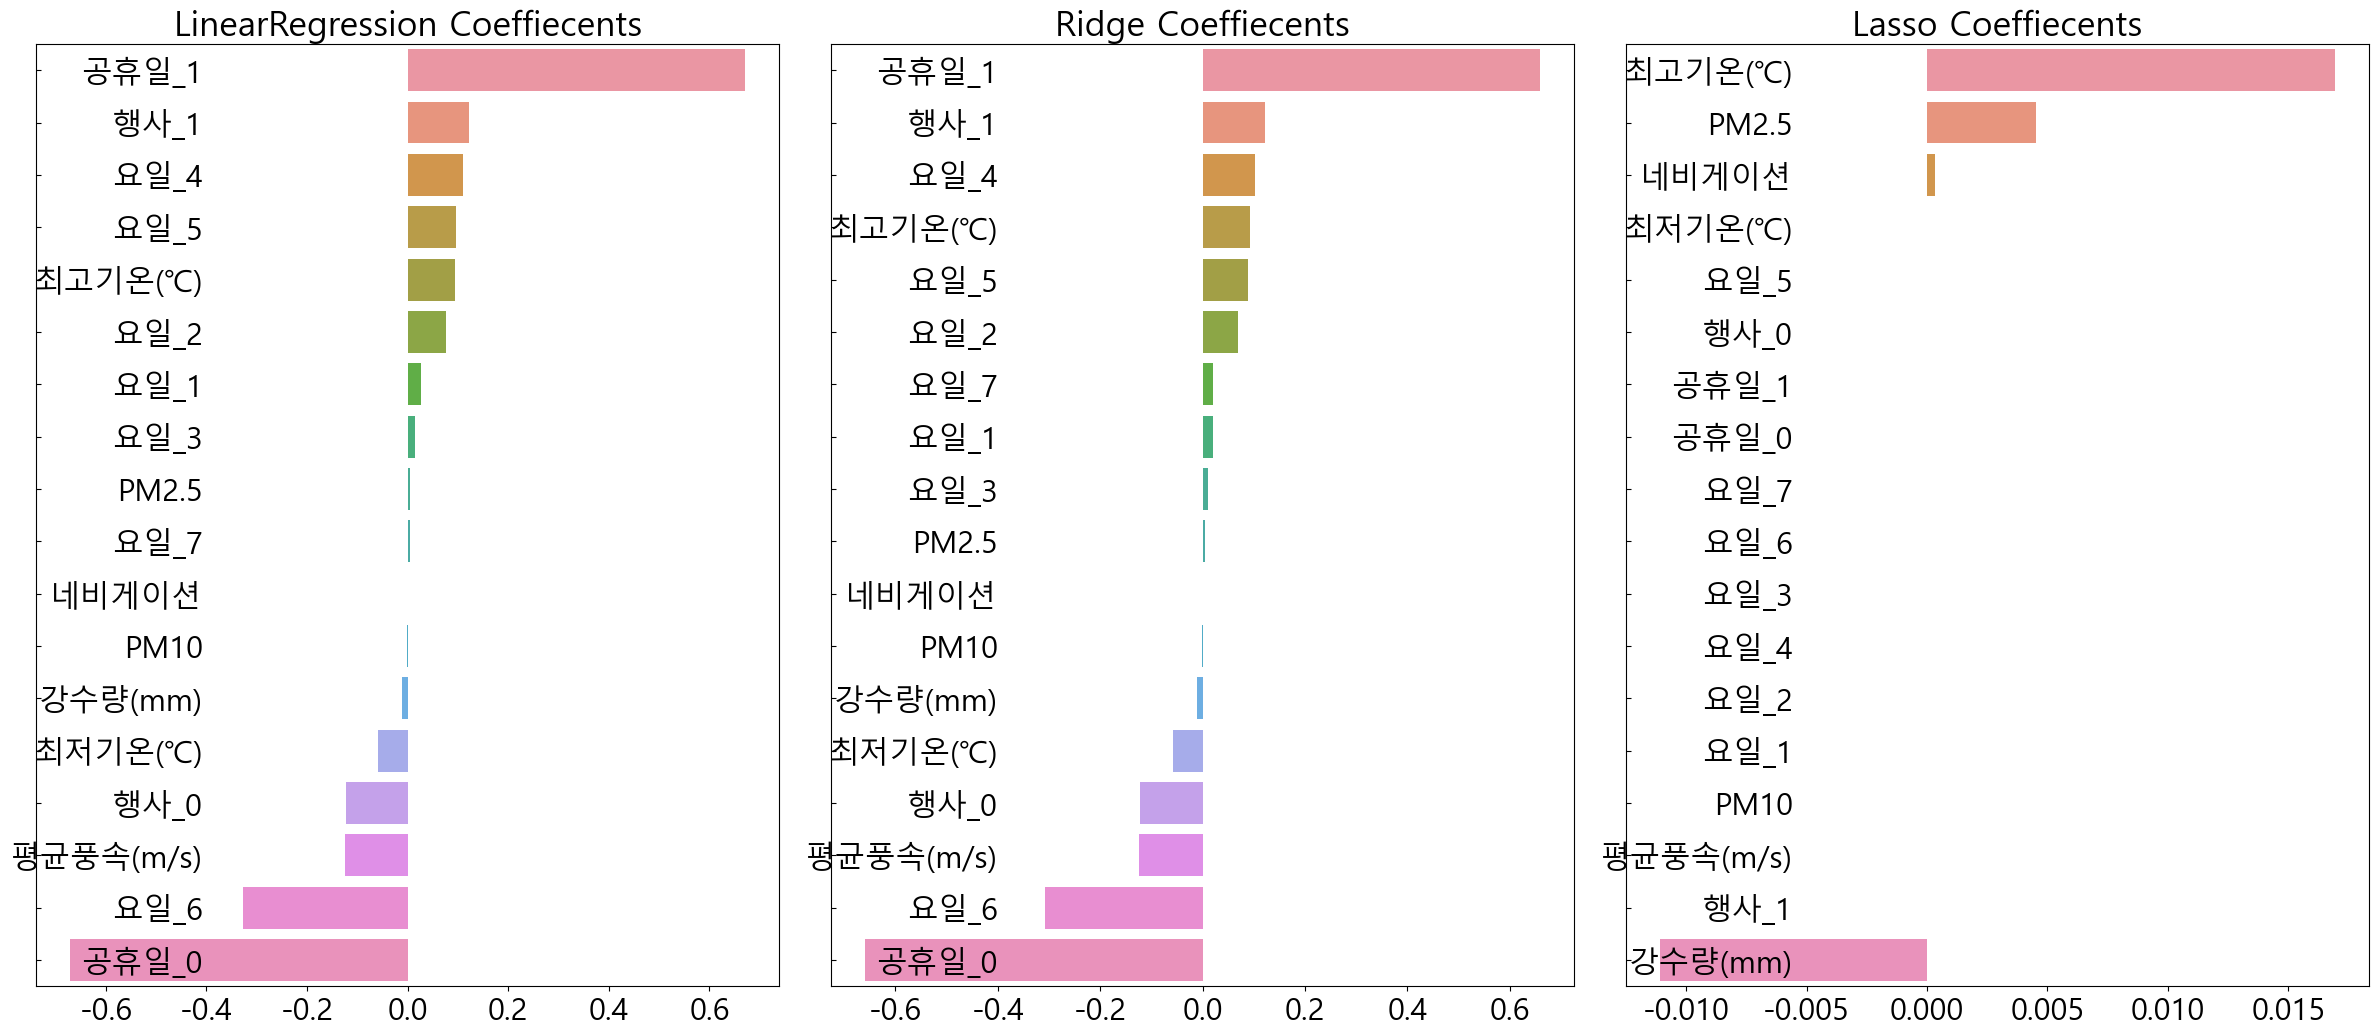

In [109]:
# 회귀계수 시각화

def get_top_bottom_coef(model) :
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    
    return coef_high, coef_low

# 모델별 회귀 계수 시각화 함수
# list 객체로 모델을 입력 받아서
# 모델별로 회귀 계수 상위 10개, 하위 10개 추출해서
# 가로 막대 그래프 형태로 출력
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__ +' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120) # 안쪽, 패딩값
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [19]:
# 결과
# OLS 기반의 LinearRegression과 Ridge : 회귀 계수가 유사한 형태로 분포
# 라쏘 : 전체적으로 회귀 계수 값이 매우 작음.
#       - 최고기온이 가장 크고, 다른 피처의 회귀 계수는 너무 작음
#       - LinearRegression과 Ridge와 다른 회귀 계수 형태
# --> 혹시 학습 데이터의 분할에 문제가 있어서 그런 것인지
# 학습과 테스트 데이터 세트를 train_test_split()으로 분할하지 않고
# 전체 데이터 세트인 X_features와 y_target을 5개의 교차 검증 폴드 세트로 분할해서
# 평균 RMSE 측정해보기

### 3.3. 5 폴드 교차검정으로 모델별 RMSE, MAE 출력

In [110]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models) :
    
    for model in models :
        # 분할하지 않고 전체 데이터세트로 교차검증 수행
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))      

def get_avg_mae_cv(models) :
    
    for model in models :
        # 분할하지 않고 전체 데이터세트로 교차검증 수행
        mae_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_absolute_error", cv=5))
        mae_avg = np.mean(mae_list)
        print('\n{0} CV MAE 값 리스트: {1}'.format( model.__class__.__name__, np.round(mae_list, 3)))
        print('{0} CV 평균 MAE 값: {1}'.format( model.__class__.__name__, np.round(mae_avg, 3)))        


In [111]:
# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력           
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)
get_avg_mae_cv(models)


LinearRegression CV RMSE 값 리스트: [0.869 0.963 0.776 1.148 0.746]
LinearRegression CV 평균 RMSE 값: 0.9

Ridge CV RMSE 값 리스트: [0.869 0.963 0.775 1.148 0.747]
Ridge CV 평균 RMSE 값: 0.901

Lasso CV RMSE 값 리스트: [1.043 1.002 0.903 1.376 1.124]
Lasso CV 평균 RMSE 값: 1.09

LinearRegression CV MAE 값 리스트: [0.831 0.817 0.785 0.965 0.747]
LinearRegression CV 평균 MAE 값: 0.829

Ridge CV MAE 값 리스트: [0.831 0.817 0.785 0.966 0.747]
Ridge CV 평균 MAE 값: 0.829

Lasso CV MAE 값 리스트: [0.91  0.84  0.847 1.077 0.96 ]
Lasso CV 평균 MAE 값: 0.927



- 5개 폴드 세트로 학습한 후 평가해도 여전히 라쏘 모델이 다른 회귀 모델에 비해 성능이 떨어짐

#### Ridge/Lasso 모델에 대해 alpha 하이퍼 파라미터 튜닝 후 재학습/예측/평가

In [112]:
from sklearn.model_selection import GridSearchCV
# 모델과 하이퍼 파라미터 딕셔너리 객체를 받아서
# 최적화 작업의 결과를 표시하는 함수
# 릿지 모델과 라쏘 모델의 최적화 alpha 값 추출
def get_best_params_rmse(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_ # 최적 파라미터로 재학습된 모델 반환

In [113]:
ridge_params = {'alpha' : [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005, 0.008,0.05, 0.03, 0.1, 0.5, 1.5,10]}

In [114]:
best_ridge = get_best_params_rmse(ridge_reg,ridge_params)
best_lasso = get_best_params_rmse(lasso_reg,lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.9122, 최적 alpha:{'alpha': 0.05}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.9081, 최적 alpha:{'alpha': 0.03}


In [115]:
from sklearn.model_selection import GridSearchCV
# 모델과 하이퍼 파라미터 딕셔너리 객체를 받아서
# 최적화 작업의 결과를 표시하는 함수
# 릿지 모델과 라쏘 모델의 최적화 alpha 값 추출
def get_best_params_mae(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_absolute_error', cv=5)
    grid_model.fit(X_features, y_target)
    mae = (-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 MAE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(mae, 4), grid_model.best_params_))
    return grid_model.best_estimator_ # 최적 파라미터로 재학습된 모델 반환

In [116]:
ridge_params = {'alpha' : [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005, 0.008,0.05, 0.03, 0.1, 0.5, 1.5,10]}

In [117]:
best_ridge = get_best_params_mae(ridge_reg,ridge_params)
best_lasso = get_best_params_mae(lasso_reg,lasso_params)

Ridge 5 CV 시 최적 평균 MAE 값: 0.6929, 최적 alpha:{'alpha': 0.05}
Lasso 5 CV 시 최적 평균 MAE 값: 0.6927, 최적 alpha:{'alpha': 0.001}


#### 분할된 트레인/테스트세트로 학습 후 재평가

In [118]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=0.05)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.001)

In [119]:
# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.767
Ridge 로그 변환된 RMSE: 0.767
Lasso 로그 변환된 RMSE: 0.765


[0.7665726310714162, 0.7665584521313654, 0.7652067815781791]

In [120]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=0.05)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.001)

In [121]:
# 모든 모델의 MAE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_maes(models)

LinearRegression 로그 변환된 MAE: 0.587
Ridge 로그 변환된 MAE: 0.587
Lasso 로그 변환된 MAE: 0.586


[0.5872824000007963, 0.5872668865957985, 0.5860482938339874]

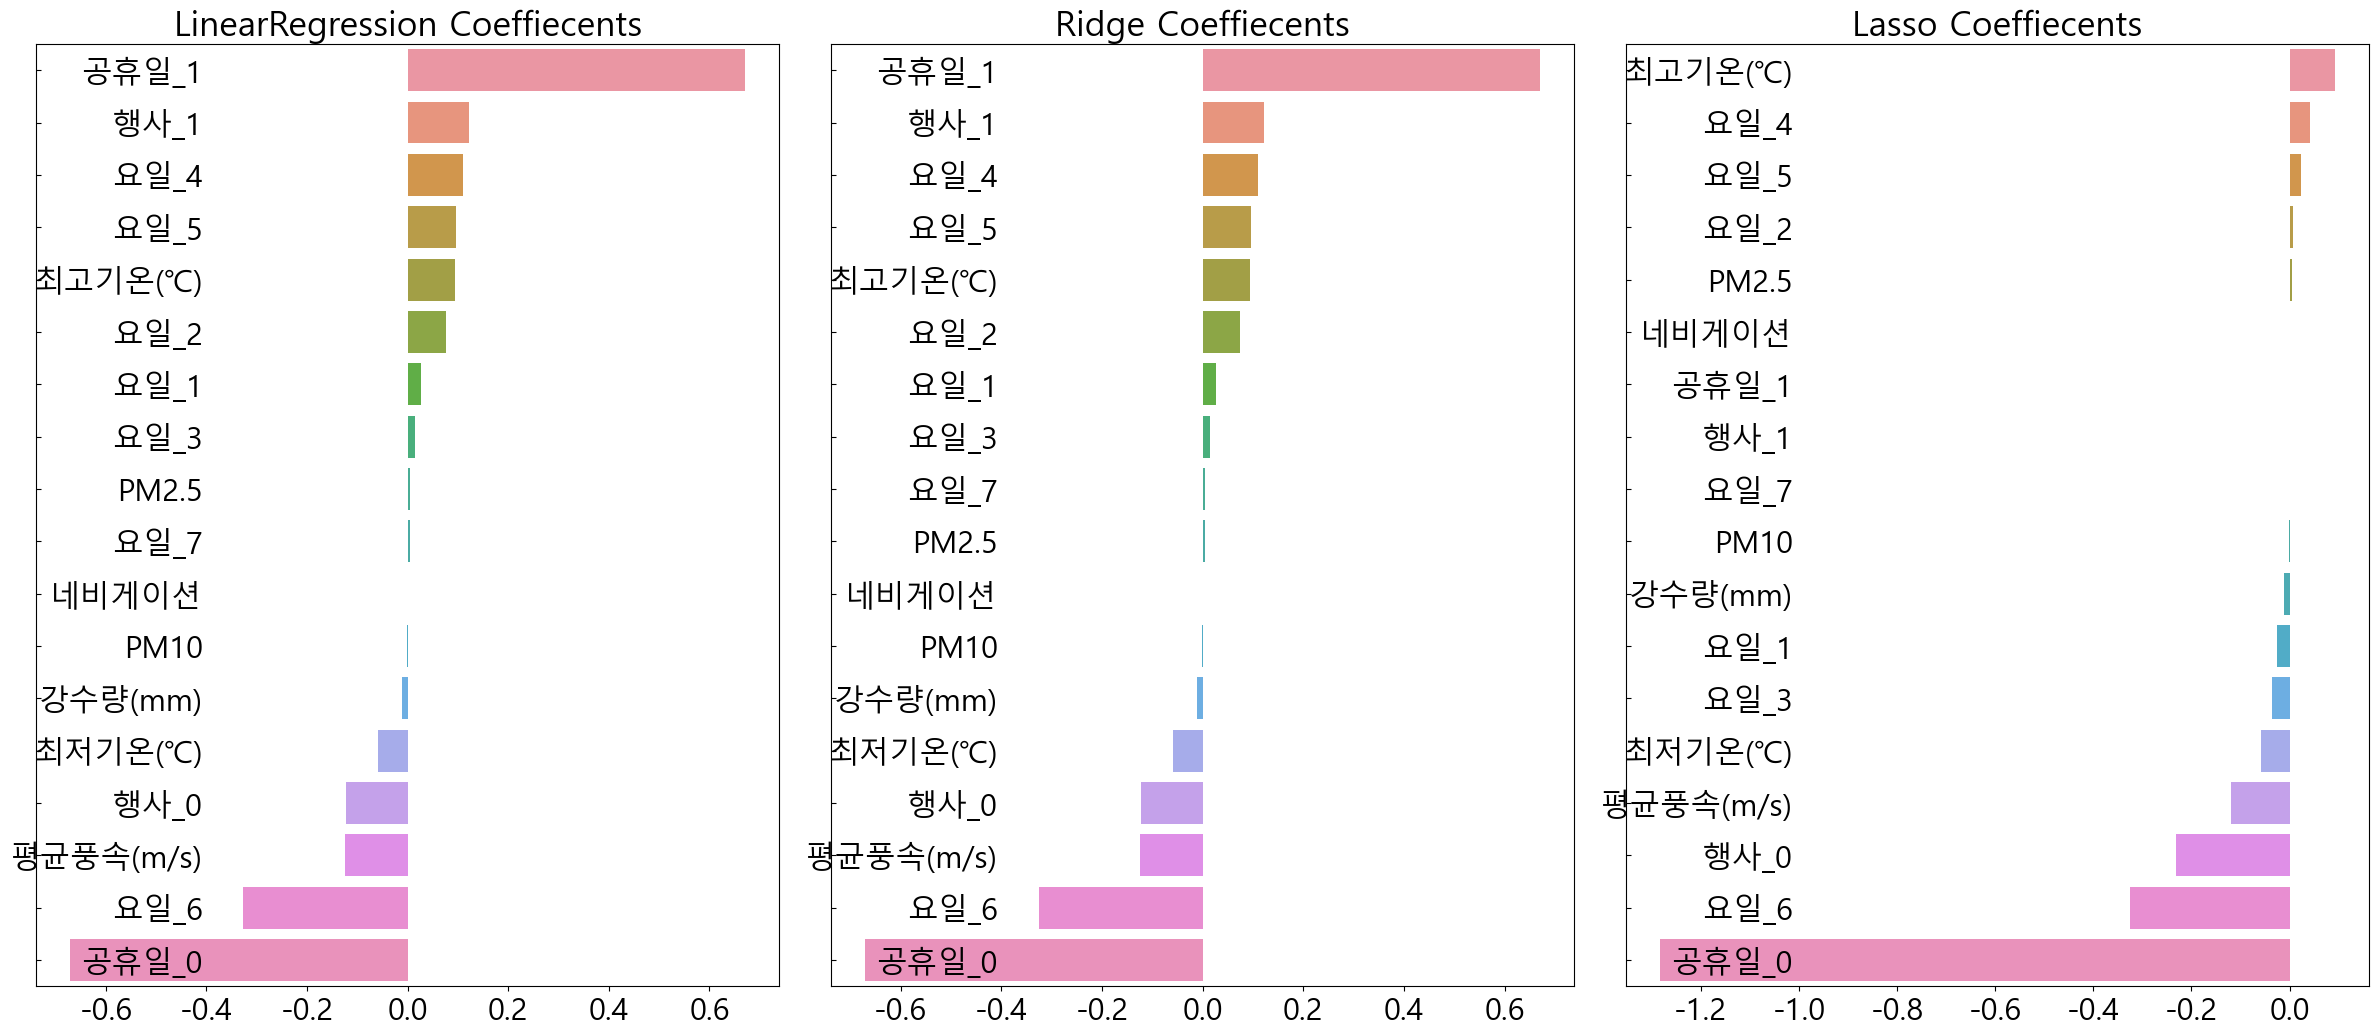

In [122]:
# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 3.4. 데이터세트 추가 가공해서 모델 튜닝 진행
- 1. 피처 데이터 세트의 데이터 분포도 확인
- 2. 이상치 데이터 처리

In [123]:
df.columns

Index(['요일', '공휴일', '최저기온(℃)', '최고기온(℃)', '강수량(mm)', '평균풍속(m/s)', 'PM2.5',
       'PM10', '네비게이션', '행사', 'Daily_Total'],
      dtype='object')

In [124]:
from scipy.stats import skew

features_index = ['PM10', 'PM2.5', '강수량(mm)', '평균풍속(m/s)', '최저기온(℃)',
       '최고기온(℃)', '네비게이션']

In [125]:
skew_features = df[features_index].apply(lambda x:skew(x)) # 각 컬럼별로 skew() 적용 위해 apply 함수 사용
# skew_features

In [126]:
#skew 정도가 1을 초과하는 컬럼들만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

# 일반적으로 skew() 함수의 반환값이 1.5이상인 경우 왜곡도가 높다고 판단하지만 상황에 따라 편차는 있음

강수량(mm)      6.612930
PM10         4.523641
네비게이션        2.028418
PM2.5        1.994710
평균풍속(m/s)    1.376264
dtype: float64


### 3.5. 왜곡이 심한 컬럼에 로그변환 후 재학습/예측/평가

In [127]:
df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

In [128]:
# 로그 변환 후 다시 왜곡 정도를 확인해 보면
skew_features = df[features_index].apply(lambda x : skew(x))
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

# 여전히 왜곡 정도가 높은 피처가 있지만 더이상 로그변환 하더라도 개선하기 어렵다고 판단
# 그대로 유지하기로 결정

강수량(mm)    2.253094
dtype: float64


In [129]:
# Skew가 높은 피처들을 로그 변환 했으므로 
# 다시 원-핫 인코딩 적용 
# 피처/타겟 데이터 세트 다시 생성
# 최적 alpha 값과 RMSE 출력

# 원-핫 인코딩
df_ohe = pd.get_dummies(df, columns=['요일','공휴일'])

# 피처/타겟 데이터 세트 다시 생성# 
y_target = df_ohe['Daily_Total']
X_features = df_ohe.drop('Daily_Total',axis=1, inplace=False)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)
# 피처 로그 변환된 data, target도 로그변환 되어 있음

In [130]:
# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

In [131]:
best_ridge = get_best_params_rmse(ridge_reg, ridge_params)
best_lasso = get_best_params_rmse(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.8977, 최적 alpha:{'alpha': 20}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.8902, 최적 alpha:{'alpha': 0.03}


In [132]:
best_ridge = get_best_params_mae(ridge_reg, ridge_params)
best_lasso = get_best_params_mae(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 MAE 값: 0.6904, 최적 alpha:{'alpha': 20}
Lasso 5 CV 시 최적 평균 MAE 값: 0.6817, 최적 alpha:{'alpha': 0.03}


In [133]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=20)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.03)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.03)

In [134]:
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.764
Ridge 로그 변환된 RMSE: 0.76
Lasso 로그 변환된 RMSE: 0.759


[0.7642732504670534, 0.7604357029483301, 0.7588615000391415]

In [135]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=20)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.03)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.03)

In [136]:
models = [lr_reg, ridge_reg, lasso_reg]
get_maes(models)

LinearRegression 로그 변환된 MAE: 0.584
Ridge 로그 변환된 MAE: 0.582
Lasso 로그 변환된 MAE: 0.581


[0.5841554704648083, 0.5819324368400173, 0.5810599641746278]

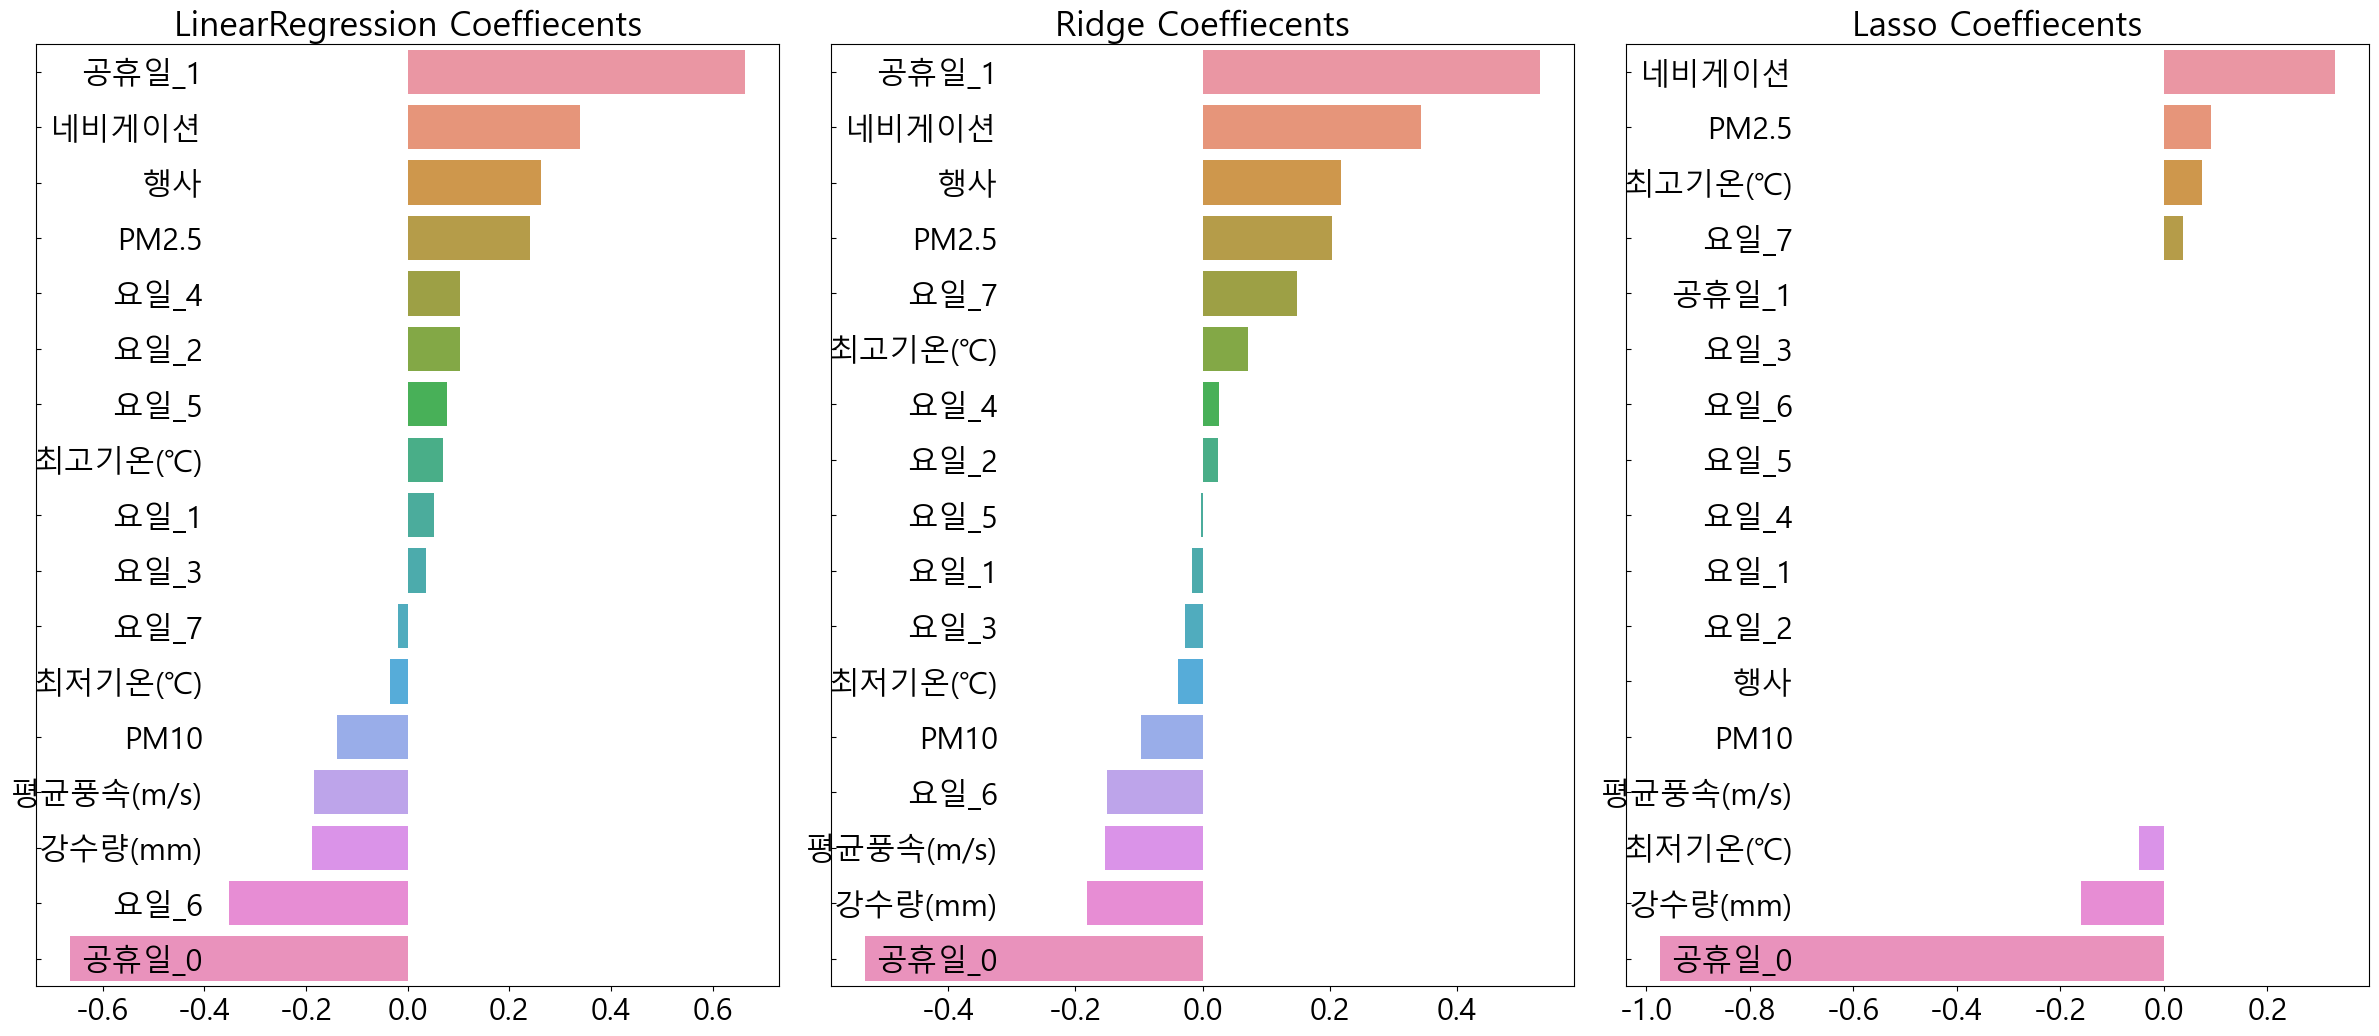

In [137]:
# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)
# 네비게이션의 회귀계수가 가장 높은 피처가 됨

### 3.6. 이상치 제거

In [138]:
df_org.describe()

,일간입장객,요일,공휴일,최저기온(℃),최고기온(℃),강수량(mm),최대풍속(m/s),평균풍속(m/s),PM2.5,PM10,네비게이션,승차총승객수,하차총승객수,행사
count,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000
mean,13133.827040,3.996346,0.320341,6.667235,17.725396,3.787272,6.719428,1.269245,23.826431,42.415956,1643.559074,69752.382460,69752.382460,0.812424
std,16004.479886,2.000301,0.466750,10.470275,9.939516,14.446422,2.466629,0.572675,17.901272,28.353184,1435.454274,18408.044495,18408.044495,0.390492
min,0.000000,1.000000,0.000000,-19.200000,-9.100000,0.000000,2.200000,0.200000,0.000000,2.000000,109.000000,17129.000000,17129.000000,0.000000
25%,3532.750000,2.000000,0.000000,-1.575000,9.700000,0.000000,4.900000,0.900000,12.000000,25.000000,675.250000,56618.250000,56618.250000,1.000000
50%,6727.000000,4.000000,0.000000,5.900000,18.700000,0.000000,6.350000,1.100000,19.000000,37.000000,1188.500000,69219.500000,69219.500000,1.000000
75%,15190.250000,6.000000,1.000000,16.300000,26.100000,0.000000,8.100000,1.500000,31.000000,55.000000,2186.250000,84988.000000,84988.000000,1.000000
max,108937.000000,7.000000,1.000000,25.800000,38.100000,182.500000,18.700000,3.900000,158.000000,525.000000,10811.000000,130404.000000,130404.000000,1.000000


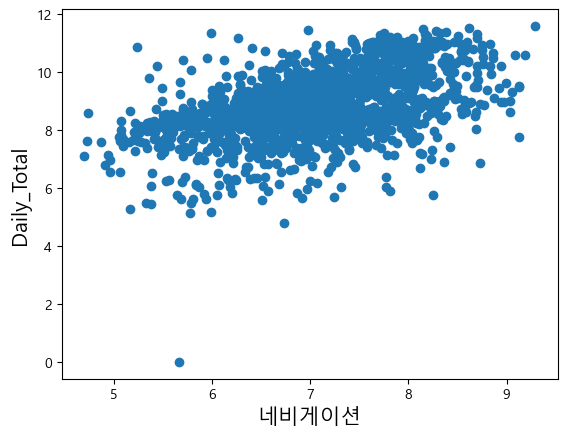

In [139]:
plt.scatter(x=df_ohe['네비게이션'], y = df_ohe['Daily_Total']) # 원본 데이터
plt.ylabel('Daily_Total', fontsize=15)
plt.xlabel('네비게이션', fontsize=15)
plt.show()

#### 이상치 데이터 제거하고 다시 학습/예측/평가

In [140]:
cond1 = df_ohe['네비게이션'] > np.log1p(5)
cond2 = df_ohe['Daily_Total'] < np.log1p(2)

In [141]:
outlier_index = df_ohe[cond1 & cond2].index
outlier_index

Index(['2019-09-07'], dtype='object', name='date')

In [142]:
print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 df_ohe shape:', df_ohe.shape)
# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제. 
df_ohe.drop(outlier_index, axis=0, inplace=True)
print('아웃라이어 삭제 후 df_ohe shape:', df_ohe.shape)

아웃라이어 레코드 index : ['2019-09-07']
아웃라이어 삭제 전 df_ohe shape: (1642, 18)
아웃라이어 삭제 후 df_ohe shape: (1641, 18)


In [143]:
# df_ohe 기반으로 피처/타깃 데이터 세트 다시 생성하고
# 릿지와 라쏘 모델의 최적화 수행

y_target = df_ohe['Daily_Total']
X_features = df_ohe.drop('Daily_Total',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

In [144]:
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

In [145]:
best_ridge = get_best_params_rmse(ridge_reg, ridge_params)
best_lasso = get_best_params_rmse(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.8681, 최적 alpha:{'alpha': 20}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.8604, 최적 alpha:{'alpha': 0.008}


In [146]:
best_ridge = get_best_params_mae(ridge_reg, ridge_params)
best_lasso = get_best_params_mae(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 MAE 값: 0.6816, 최적 alpha:{'alpha': 20}
Lasso 5 CV 시 최적 평균 MAE 값: 0.6728, 최적 alpha:{'alpha': 0.008}


In [147]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=20)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.008)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.008)

In [148]:
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.761
Ridge 로그 변환된 RMSE: 0.761
Lasso 로그 변환된 RMSE: 0.761


[0.7608894272268519, 0.7608294717907816, 0.7605080785518015]

In [149]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=20)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.008)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.008)

In [150]:
models = [lr_reg, ridge_reg, lasso_reg]
get_maes(models)

LinearRegression 로그 변환된 MAE: 0.587
Ridge 로그 변환된 MAE: 0.588
Lasso 로그 변환된 MAE: 0.586


[0.5871565874741971, 0.58754794825069, 0.5863861477342651]

## 4. 회귀 트리 학습/예측/평가

- df_ohe 되돌리기

In [151]:
df_ohe = pd.get_dummies(df, columns=['요일','공휴일','행사'])

In [152]:
df_ohe

,최저기온(℃),최고기온(℃),강수량(mm),평균풍속(m/s),PM2.5,PM10,네비게이션,Daily_Total,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6,요일_7,공휴일_0,공휴일_1,행사_0,행사_1
date,,,,,,,,,,,,,,,,,,,
2018-01-01,-8.7,4.2,0.000000,0.788457,3.433987,4.025352,6.647688,9.451952,1,0,0,0,0,0,0,0,1,0,1
2018-01-02,-8.0,3.6,0.000000,0.832909,3.637586,4.127134,5.894403,8.600247,0,1,0,0,0,0,0,1,0,0,1
2018-01-03,-9.8,1.8,0.000000,0.916291,3.218876,3.828641,5.602119,8.246958,0,0,1,0,0,0,0,1,0,0,1
2018-01-04,-10.6,-0.9,0.000000,0.641854,3.555348,4.127134,5.749393,8.213382,0,0,0,1,0,0,0,1,0,0,1
2018-01-05,-8.3,2.5,0.000000,0.832909,3.871201,4.356709,5.902633,8.335192,0,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,22.5,28.6,0.000000,0.741937,3.784190,3.583519,7.057898,10.930210,0,0,0,0,0,0,1,0,1,1,0
2022-06-27,23.5,28.6,1.945910,0.741937,3.258097,2.772589,6.706862,7.216709,1,0,0,0,0,0,0,1,0,1,0
2022-06-28,25.6,28.9,0.000000,1.435085,2.197225,1.791759,6.376727,7.089243,0,1,0,0,0,0,0,1,0,1,0


In [153]:
# 비선형회귀 간단하게 돌려보니 랜덤포레스트가 제일 잘나옴

from sklearn.ensemble import RandomForestRegressor

rf_params = {'random_state':[0],'n_estimators':[500,1000]}
rf_res = RandomForestRegressor(n_estimators=1000)
best_rf = get_best_params_rmse(rf_res,rf_params)

rf_params = {'random_state':[0],'n_estimators':[500,1000]}
rf_res = RandomForestRegressor(n_estimators=1000)
best_rf = get_best_params_mae(rf_res,rf_params)

RandomForestRegressor 5 CV 시 최적 평균 RMSE 값: 0.8747, 최적 alpha:{'n_estimators': 500, 'random_state': 0}
RandomForestRegressor 5 CV 시 최적 평균 MAE 값: 0.6753, 최적 alpha:{'n_estimators': 1000, 'random_state': 0}


## 5. 회귀 모델들의 예측 결과 혼합을 통한 최종 예측

- 선형회귀 Ridge / Lasso 혼합

In [154]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# 최종 혼합 모델과 개별 모델의 RMSE 값 출력하는 함수 생성
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))
        
def get_mae_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mae = mean_absolute_error(y_test , pred_value)
        print('{0} 모델의 MAE: {1}'.format(key, mae))

In [155]:
# 개별 모델 학습
ridge_reg = Ridge(alpha=20)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.008)
lasso_reg.fit(X_train, y_train)
# 개별모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

In [156]:
# 개별 모델 예측값 혼합으로 최종 예측값 도출 - ridge:60% / lasso:40%
pred = ridge_pred*0.6 + lasso_pred*0.4

In [157]:
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}

#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)
get_mae_pred(preds)

최종 혼합 모델의 RMSE: 0.7604665276786181
Ridge 모델의 RMSE: 0.7608294717907816
Lasso 모델의 RMSE: 0.7605080785518015
최종 혼합 모델의 MAE: 0.5869798217565481
Ridge 모델의 MAE: 0.58754794825069
Lasso 모델의 MAE: 0.5863861477342651


- 비선형회귀 XGBoost와 LightGBM 혼합

In [158]:
xgb_reg = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
lgbm_reg = LGBMRegressor(n_estimators=1000)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

In [159]:
pred = xgb_pred*0.5 + lgbm_pred*0.5
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
        
get_rmse_pred(preds)
get_mae_pred(preds)

최종 혼합 모델의 RMSE: 0.7836804515452376
XGBM 모델의 RMSE: 0.7884519853829135
LGBM 모델의 RMSE: 0.8238350183453984
최종 혼합 모델의 MAE: 0.5971619143584822
XGBM 모델의 MAE: 0.609994828627049
LGBM 모델의 MAE: 0.6150863010914728


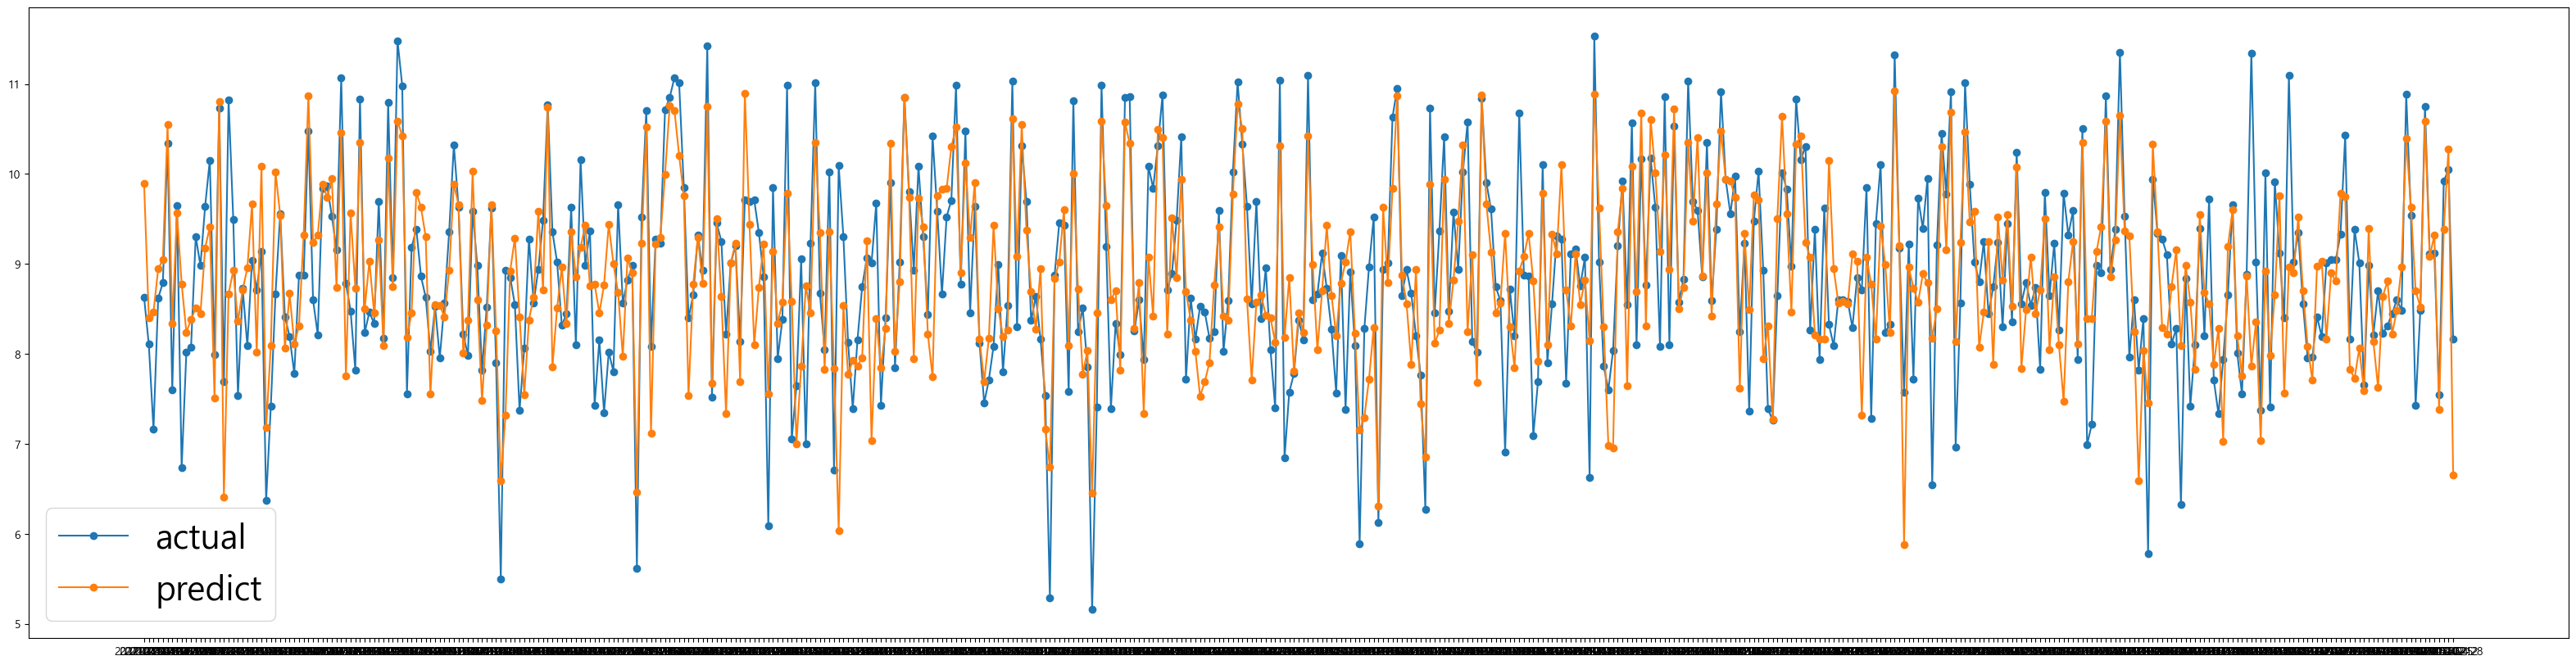

In [160]:
fig, ax1  = plt.subplots(nrows=1)
fig.set_size_inches(40,10)

ax1.plot(y_test, marker = "o" , label = "actual")
ax1.plot(pred, marker = "o", label = "predict")
ax1.legend(prop={'size':30})

## 6. ElasticNet

In [76]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True, return_coeff=True):
#     coeff_df = pd.DataFrame()
#     if verbose: print('#####', model_name,'#####')
#     for param in params:
#         if model_name == 'Ridge': model = Ridge(alpha=param)
#         elif model_name == 'Lasso': model = Lasso(alpha=param)
#         elif model_name == 'ElasitcNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
#         neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring='neg_mean_squared_error', cv=5)
#         avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
#         print('alpha {0}일 때 5폴드 세트의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))
#         # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        
#         model.fit(X_data_n, y_target_n)

In [77]:
# 엘라스틱넷에 사용될 alpha 파라미터 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [0.07,0.1,0.5,1,3]
for alpha in elastic_alphas:
    elasticnet = ElasticNet(alpha=alpha)
    
    neg_mse_scores = cross_val_score(elasticnet, X_features, y_target, scoring='neg_mean_squared_error', cv=5)
    neg_mae_scores = cross_val_score(elasticnet, X_features, y_target, scoring='neg_mean_absolute_error', cv=5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    avg_mae = np.mean(-1*neg_mae_scores)
    print('alpha {0}일 때 5폴드 세트의 평균 RMSE: {1:.3f}'.format(alpha, avg_rmse))
    print('alpha {0}일 때 5폴드 세트의 평균 MAE: {1:.3f}'.format(alpha, avg_mae))

alpha 0.07일 때 5폴드 세트의 평균 RMSE: 0.706
alpha 0.07일 때 5폴드 세트의 평균 MAE: 0.536
alpha 0.1일 때 5폴드 세트의 평균 RMSE: 0.719
alpha 0.1일 때 5폴드 세트의 평균 MAE: 0.549
alpha 0.5일 때 5폴드 세트의 평균 RMSE: 0.972
alpha 0.5일 때 5폴드 세트의 평균 MAE: 0.782
alpha 1일 때 5폴드 세트의 평균 RMSE: 1.073
alpha 1일 때 5폴드 세트의 평균 MAE: 0.862
alpha 3일 때 5폴드 세트의 평균 RMSE: 1.094
alpha 3일 때 5폴드 세트의 평균 MAE: 0.877


- ElasticNet은 기대했던 것보다 성능이 그렇게까지 좋진 않아보입니다..

## 7. 스태킹 앙상블 모델

In [161]:
from sklearn.model_selection import KFold #트레인데이터를 학습/검증 세트로 분리하기 위해 필요
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=6)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=100)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=100)
xgb_reg = XGBRegressor(n_estimators=100)
lgbm_reg = LGBMRegressor(n_estimators=100)

In [162]:
# 개별 기반 모델(1개의 모델) 최종 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
# Fold를 사용하도록 구성(사용자정의함수- 구성방법은 개발자가 결정)
def get_stacking_base_datasets(model, X_train_n,y_train_n,X_test_n,n_folds) :
    # 지정된 n_folds 값으로 KFold 객체 생성
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=0)
    # 데이터 분할이 아닌 행 인덱스만 분할함
    
    # 최종모델이 사용할 학습 데이터를 위한 초기 구성 - 넘파이배열로 생성
    train_fold_pred = np.zeros((X_train_n.shape[0],1)) # 0으로 저장되어 있는 빈 배열
    test_pred = np.zeros((X_test_n.shape[0],n_folds)) # 0으로 저장되어 있는 빈 배열
    print(model.__class__.__name__ , ' model 시작 ')
    
    # kf.split(X_train_n) 데이터의 인덱스를 분할한 결과 반환
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
       #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] # 학습 데이터
        y_tr = y_train_n[train_index] # 학습 데이터 타겟
        X_te = X_train_n[valid_index] # 검증 데이터
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr) # 개별모델로 학습
        
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1) # 예측데이터 저장-검증데이터에 대해서 예측 진행
        
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n) # 테스트 데이터에 대해 예측해서 저장
        
    # 테스트 데이터를 폴드세트의 평균으로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, 
    # test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [163]:
# 생성한 함수가 ndarray를 인자로 사용하므로 DF를 ndarray로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

In [164]:
# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [165]:
# 각 개별 모델이 반환한 학습용피처 데이터와 테스트용피터 데이터 세트를 결합해서 최종데이터세트 생성
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)

In [166]:
# 최종 모델 라쏘 모델을 적용
meta_model_lasso = Lasso(alpha=0.001)

In [167]:
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, final)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)
print('스태킹 회귀 모델의 최종 MAE 값은:', mae)

스태킹 회귀 모델의 최종 RMSE 값은: 0.7272842886479979
스태킹 회귀 모델의 최종 MAE 값은: 0.5484843900980071


In [168]:
# 최종 모델 릿지 모델을 적용
meta_model_ridge = Ridge(alpha=1)
meta_model_ridge.fit(Stack_final_X_train, y_train)
final = meta_model_ridge.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, final)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)
print('스태킹 회귀 모델의 최종 MAE 값은:', mae)

스태킹 회귀 모델의 최종 RMSE 값은: 0.7269257437034942
스태킹 회귀 모델의 최종 MAE 값은: 0.548032864135789


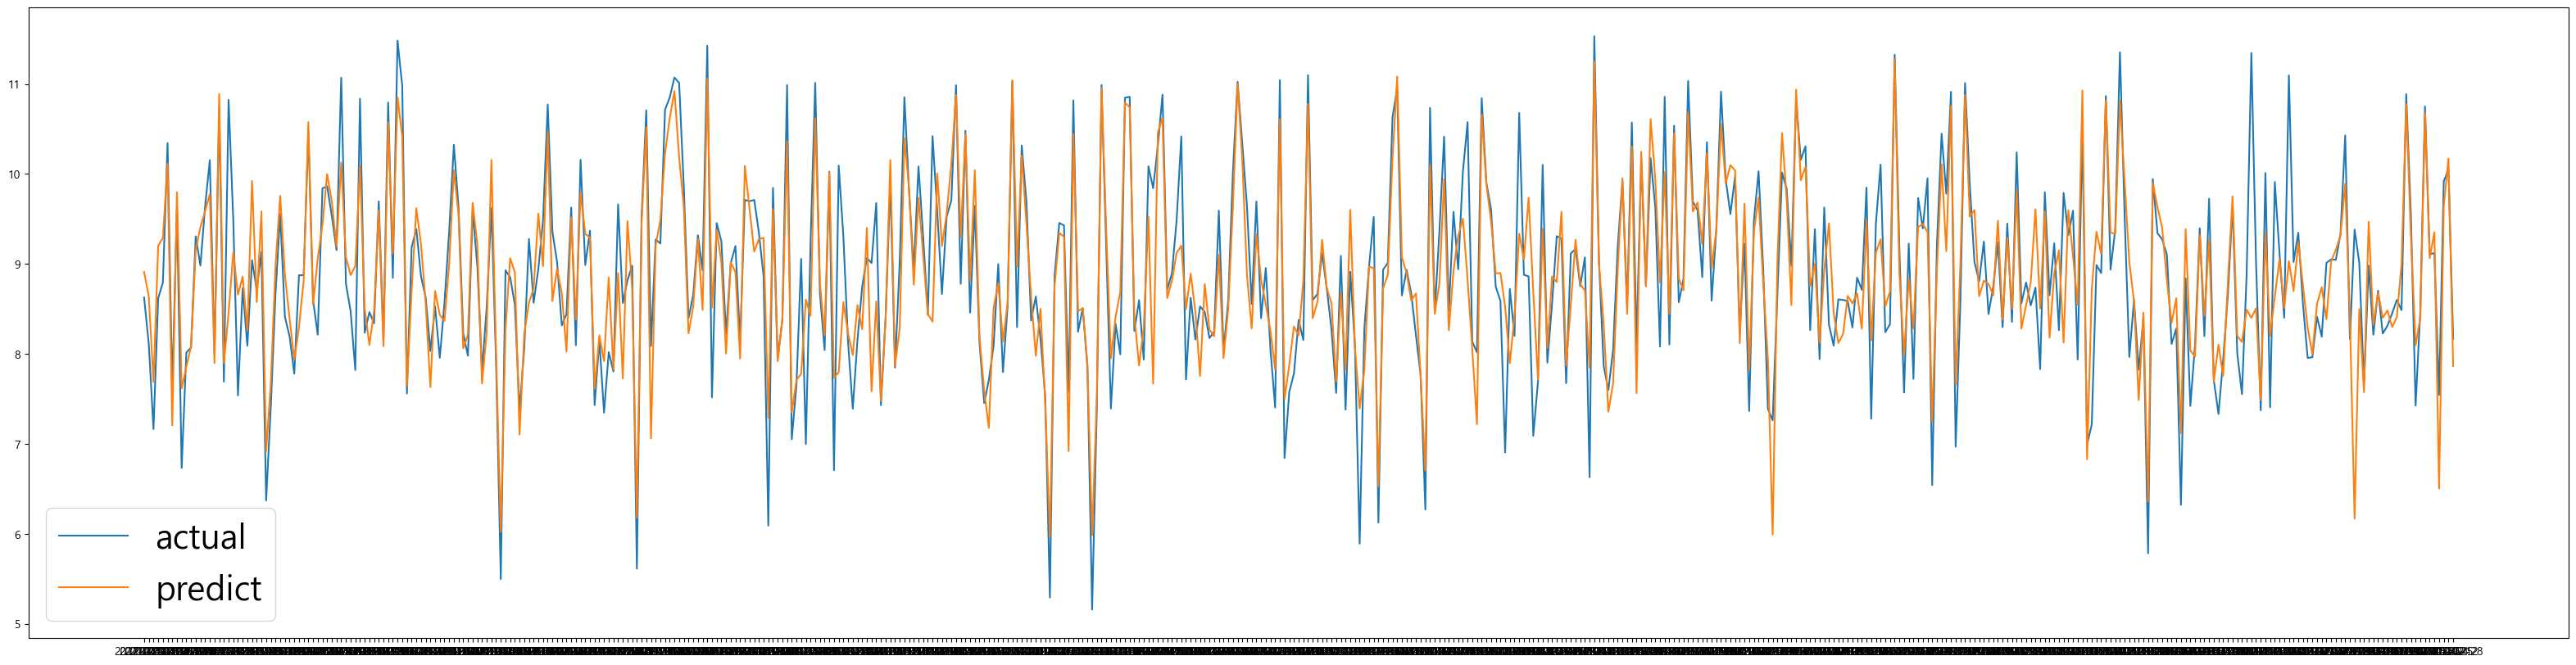

In [92]:
fig, ax1  = plt.subplots(nrows=1)
fig.set_size_inches(40,10)

ax1.plot(y_test, label = "actual") 
ax1.plot(final, label = "predict") 
ax1.legend(prop={'size':30})